### CNN Model

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import random
import math
from datetime import datetime

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint 

from sklearn.preprocessing import LabelEncoder


In [ ]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath("/content/drive/MyDrive/UrbanSound8K")
audio_path = os.path.join(us8k_path, "/content/drive/MyDrive/UrbanSound8K/audio")
metadata_path = os.path.join(us8k_path, "/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv")
models_path = os.path.abspath("./models")
data_path = os.path.abspath("./data")

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [ ]:
# Pre-processed data
X = np.load("/content/drive/MyDrive/UrbanSound8K/X-mel_spec.npy")
y = np.load("/content/drive/MyDrive/UrbanSound8K/y-mel_spec.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

### Data Preparation

In [ ]:
# Train/Test Split

indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 128, 174) 	 X train shape: (6986, 128, 174)
y test shape: (1746,) 		 y train shape: (6986,)


In [ ]:
# Encoding labes
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [ ]:
y_test_encoded.shape, y_train_encoded.shape

((1746, 10), (6986, 10))

In [ ]:
# Reshaping data
# How data should be structured
num_rows = 128
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

### CNN Network

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

### Setup model optimizer and loss function

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 172, 32)      320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 172, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 126, 172, 32)     128       
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 126, 172, 32)     0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 170, 32)      9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 124, 170, 32)      0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training the model

num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/360
51/51 [==============================] - ETA: 0s - loss: 2.1944 - accuracy: 0.2033
Epoch 1: val_loss improved from inf to 2.73144, saving model to /content/models/simple-train-nb3.hdf5
51/51 [==============================] - 30s 287ms/step - loss: 2.1944 - accuracy: 0.2033 - val_loss: 2.7314 - val_accuracy: 0.1286
Epoch 2/360
50/51 [============================>.] - ETA: 0s - loss: 2.0058 - accuracy: 0.2664
Epoch 2: val_loss improved from 2.73144 to 2.60538, saving model to /content/models/simple-train-nb3.hdf5
51/51 [==============================] - 13s 263ms/step - loss: 2.0058 - accuracy: 0.2663 - val_loss: 2.6054 - val_accuracy: 0.1664
Epoch 3/360
50/51 [============================>.] - ETA: 0s - loss: 1.9280 - accuracy: 0.3086
Epoch 3: val_loss improved from 2.60538 to 2.26656, saving model to /content/models/simple-train-nb3.hdf5
51/51 [==============================] - 14s 266ms/step - loss: 1.9278 - accuracy: 0.3086 - val_loss: 2.2666 - val_accuracy: 0.2453
Epoch

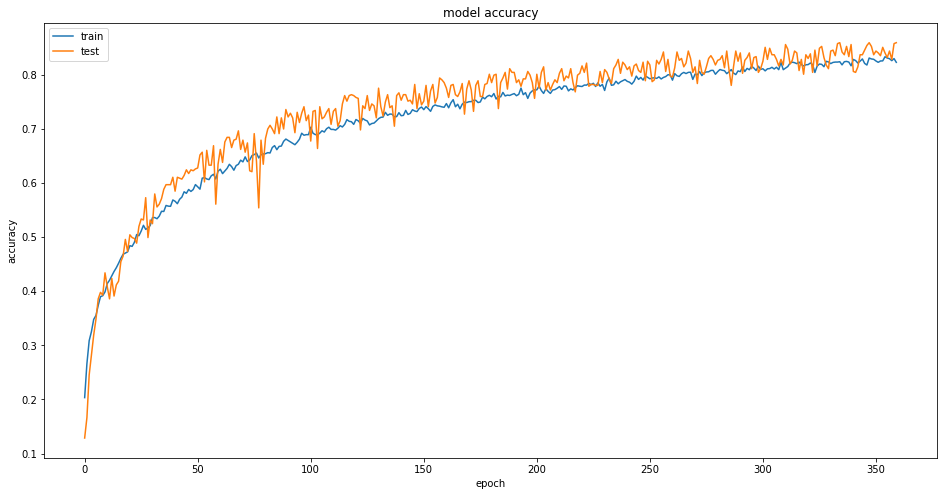

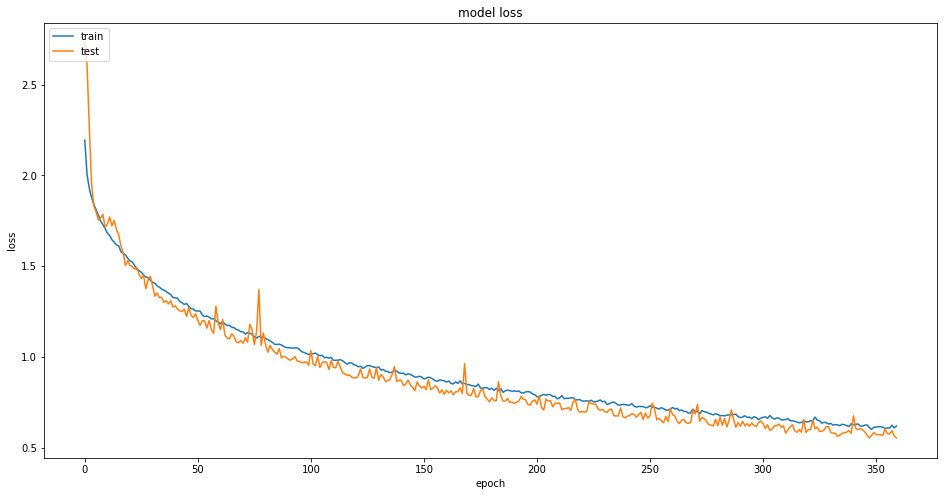

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()